In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import json
from unidecode import unidecode
from nltk.tokenize import word_tokenize

In [124]:
def clean_name(name):
    name = name.replace('"', '')
    return unidecode(name)

In [141]:
# Read the data from the csv file
senate_df = pd.read_csv('usa_data/senators.csv')
house_df = pd.read_csv('usa_data/house.csv')

# clean all names
senate_df['Senator'] = senate_df['Senator'].apply(clean_name)
house_df['Member'] = house_df['Member'].apply(clean_name)

senators = senate_df['Senator'].tolist()
representatives = house_df['Member'].tolist()

senators_names = [clean_name(name) for name in senators]
representatives = [clean_name(name) for name in representatives]

# remove representatives that are vacant
representatives = [x for x in representatives if x != 'Vacant']

In [75]:
# load the JSON string back into a dictionary
with open('usa_data/house_links.json', 'r') as f:
    house_links = json.loads(f.read())

with open('usa_data/senate_links.json', 'r') as f:
    senate_links = json.loads(f.read())

In [221]:
# create a graph object
congress_dict = {**house_links, **senate_links}

congress_graph = nx.DiGraph()

# add nodes to the graph
congress_graph.add_nodes_from(senators)
congress_graph.add_nodes_from(representatives)

for key, values in congress_dict.items():
    for value in values:
        congress_graph.add_edge(key, value)

party = senate_df['Party'].unique().tolist()

# add house, senate and state attributes to the nodes
for node in congress_graph.nodes():
    if node in senators:
        congress_graph.nodes[node]['chamber'] = 'Senate'
        try: 
            congress_graph.nodes[node]['party'] = senate_df.loc[senate_df['Senator'] == node]['Party'].values[0]
            congress_graph.nodes[node]['state'] = senate_df.loc[senate_df['Senator'] == node]['State'].values[0]
        except:
            print(node)
            print(senate_df.loc[senate_df['Senator'] == node]['Party'].values)
        

    elif node in representatives:
        try: 
            congress_graph.nodes[node]['chamber'] = 'House'
            congress_graph.nodes[node]['party'] = house_df.loc[house_df['Member'] == node]['Party'].values[0]
            congress_graph.nodes[node]['state'] = house_df.loc[house_df['Member'] == node]['District'].values[0]
        except:
            print(node)
            print(house_df.loc[house_df['Member'] == node]['Party'].values)



print(congress_graph)
# to do, remove number on district

DiGraph with 533 nodes and 3026 edges


In [222]:
# find most connected node based on House

# find most connected rappers from east and west coast
in_degrees = sorted(congress_graph.in_degree, key=lambda x: x[1], reverse=True)
out_degrees = sorted(congress_graph.out_degree, key=lambda x: x[1], reverse=True)

in_house = []
in_senate = []
out_house = []
out_senate = []

for node in in_degrees:
    if congress_graph.nodes[node[0]]['chamber'] == 'House':
        in_house.append(node)
    else:
        in_senate.append(node)

for node in out_degrees:
    if congress_graph.nodes[node[0]]['chamber'] == 'House':
        out_house.append(node)
    else:
        out_senate.append(node)


In [223]:
# Most connected east coast rappers
print("Top 5 highest out-degree members of house of representatives:")
for i in range(5):
    print(str(i+1)+ ")"+str(out_house[i])[1:-1])

print("\n")
print("Top 5 highest out-degree members of senate:")
for i in range(5):
    print(str(i+1)+ ")"+str(out_senate[i])[1:-1])

Top 5 highest out-degree members of house of representatives:
1)'Marjorie Taylor Greene', 34
2)'Chip Roy', 31
3)'Alexandria Ocasio-Cortez', 27
4)'Kevin McCarthy', 26
5)'Josh Gottheimer', 21


Top 5 highest out-degree members of senate:
1)'Joe Manchin', 31
2)'Chuck Schumer', 24
3)'Tom Cotton', 22
4)'Ron Wyden', 22
5)'Bernie Sanders', 22


In [224]:
# Most connected east coast rappers
print("Top 5 highest in-degree members of house of representatives:")
for i in range(5):
    print(str(i+1)+ ")"+str(in_house[i])[1:-1])

print("\n")
print("Top 5 highest in-degree members of senate:")
for i in range(5):
    print(str(i+1)+ ")"+str(in_senate[i])[1:-1])

Top 5 highest in-degree members of house of representatives:
1)'Nancy Pelosi', 100
2)'Kevin McCarthy', 71
3)'Alexandria Ocasio-Cortez', 35
4)'Marjorie Taylor Greene', 32
5)'Jim Jordan', 25


Top 5 highest in-degree members of senate:
1)'Bernie Sanders', 62
2)'Ted Cruz', 43
3)'Mitch McConnell', 40
4)'Chuck Schumer', 40
5)'Elizabeth Warren', 38


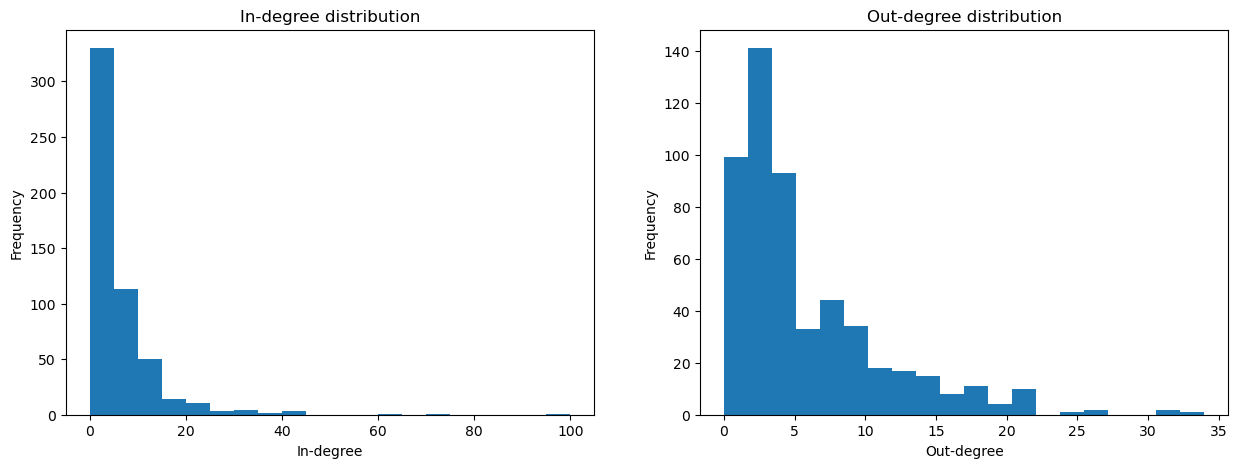

In [225]:
# Make histogram of in and out degree graph
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist([x[1] for x in in_degrees], bins=20)
plt.title('In-degree distribution')
plt.xlabel('In-degree')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist([x[1] for x in out_degrees], bins=20)
plt.title('Out-degree distribution')
plt.xlabel('Out-degree')
plt.ylabel('Frequency')
plt.show()

In [226]:
# draw the graph

color = []

for node in congress_graph.nodes():
    if congress_graph.nodes[node]['party'] == 'Republican':
        color.append('red')
    elif congress_graph.nodes[node]['party'] == 'Democratic':
        color.append('blue')
    else:
        color.append('green')

size = [degree*10 for node, degree in congress_graph.degree()]

# remove isolated nodes
#congress_graph.remove_nodes_from(list(nx.isolates(congress_graph)))

# remove self loops
#congress_graph.remove_edges_from(nx.selfloop_edges(congress_graph))

In [227]:
pos = nx.kamada_kawai_layout(congress_graph)

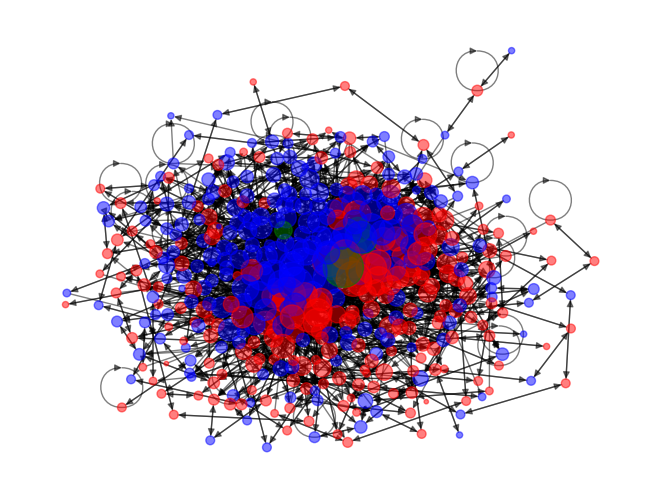

In [228]:
nx.draw(congress_graph, pos, font_size=8, node_color=color, node_size=size, alpha=0.5)

In [229]:
# create table with all the nodes stats
stats_df = pd.DataFrame()

for node in congress_graph.nodes():
    new_row = pd.DataFrame([[node, 
                            congress_graph.in_degree(node),
                            congress_graph.out_degree(node), 
                            nx.degree_centrality(congress_graph)[node]
                            ]])
    stats_df = pd.concat([stats_df,new_row], axis = 0, ignore_index=True)


# set the column names
stats_df.columns = ['Name', 'In-degree', 'Out-degree', 'Degree centrality']
print(stats_df)

                 Name  In-degree  Out-degree  Degree centrality
0    Tommy Tuberville          6           5           0.020677
1         Katie Britt          5           9           0.026316
2      Lisa Murkowski         14          12           0.048872
3        Dan Sullivan          0           0           0.000000
4      Kyrsten Sinema         14          18           0.060150
..                ...        ...         ...                ...
528  Scott Fitzgerald          0           0           0.000000
529    Glenn Grothman          1           1           0.003759
530       Tom Tiffany          2           1           0.005639
531    Mike Gallagher          0           0           0.000000
532   Harriet Hageman          2           4           0.011278

[533 rows x 4 columns]


In [231]:
# print nodes with highest degree centrality
print("Top 5 highest degree centrality:")
print(stats_df.sort_values(by=['Degree centrality'], ascending=False).head(10))

Top 5 highest degree centrality:
                         Name  In-degree  Out-degree  Degree centrality
131              Nancy Pelosi        100          18           0.221805
140            Kevin McCarthy         71          26           0.182331
88             Bernie Sanders         62          22           0.157895
228    Marjorie Taylor Greene         32          34           0.124060
62              Chuck Schumer         40          24           0.120301
85                   Ted Cruz         43          21           0.120301
370  Alexandria Ocasio-Cortez         35          27           0.116541
40           Elizabeth Warren         38          17           0.103383
94                Joe Manchin         21          31           0.097744
16                Marco Rubio         34          16           0.093985
